In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from assets.LSTM import LSTM
from assets.Transformer import Transformer
import numpy as np
import torch.optim as optim
import torch.utils.data as data
from sklearn.preprocessing import MinMaxScaler

In [2]:
def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset
    
    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X,dtype=torch.float32), torch.tensor(y,dtype=torch.float32)

In [3]:
raw_data = pd.read_csv("./data/data.csv")

In [4]:
df = raw_data[raw_data['unique_id']=='AAAHol']

In [5]:
scaler = MinMaxScaler()
df['visits_scaled'] = scaler.fit_transform(df[['visits']])

/var/folders/n0/h0y2mn7n655844sg5fmgh4gwm203r_/T/ipykernel_9161/1879581720.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['visits_scaled'] = scaler.fit_transform(df[['visits']])


In [6]:
# train-test split for time series
timeseries = df[['visits_scaled']].values.astype('float32')
train_size = int(len(timeseries) * 0.67)
test_size = len(timeseries) - train_size
train, test = timeseries[:train_size], timeseries[train_size:]

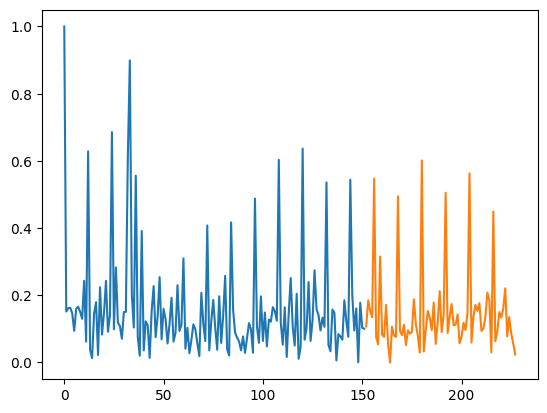

In [7]:
plt.plot(train)
plt.plot(np.arange(len(train),len(train)+len(test)),test)
plt.show()

In [8]:
lookback = 32
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([120, 32, 1]) torch.Size([120, 32, 1])
torch.Size([44, 32, 1]) torch.Size([44, 32, 1])


/var/folders/n0/h0y2mn7n655844sg5fmgh4gwm203r_/T/ipykernel_9161/4182971521.py:14: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(X,dtype=torch.float32), torch.tensor(y,dtype=torch.float32)


In [10]:
lstm = LSTM(input_size=32,hidden_size=256)
optimizer = optim.Adam(lstm.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train,y_train),shuffle=True,batch_size=8)

In [11]:
n_epochs = 2000
for epoch in range(n_epochs):
    lstm.train()
    for X_batch, y_batch in loader:
        y_pred = lstm(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 100 != 0:
        continue
    lstm.eval()
    with torch.no_grad():
        y_pred = lstm(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = lstm(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))


Epoch 0: train RMSE 0.1546, test RMSE 0.1279
Epoch 100: train RMSE 0.0595, test RMSE 0.1070
Epoch 200: train RMSE 0.0500, test RMSE 0.1114
Epoch 300: train RMSE 0.0465, test RMSE 0.1152
Epoch 400: train RMSE 0.0459, test RMSE 0.1216
Epoch 500: train RMSE 0.0407, test RMSE 0.1182
Epoch 600: train RMSE 0.0391, test RMSE 0.1167
Epoch 700: train RMSE 0.0399, test RMSE 0.1212
Epoch 800: train RMSE 0.0395, test RMSE 0.1247
Epoch 900: train RMSE 0.0363, test RMSE 0.1216
Epoch 1000: train RMSE 0.0353, test RMSE 0.1234
Epoch 1100: train RMSE 0.0345, test RMSE 0.1250
Epoch 1200: train RMSE 0.0351, test RMSE 0.1218
Epoch 1300: train RMSE 0.0347, test RMSE 0.1163
Epoch 1400: train RMSE 0.0357, test RMSE 0.1230
Epoch 1500: train RMSE 0.0385, test RMSE 0.1189
Epoch 1600: train RMSE 0.0330, test RMSE 0.1241
Epoch 1700: train RMSE 0.0338, test RMSE 0.1267
Epoch 1800: train RMSE 0.0331, test RMSE 0.1257
Epoch 1900: train RMSE 0.0338, test RMSE 0.1220


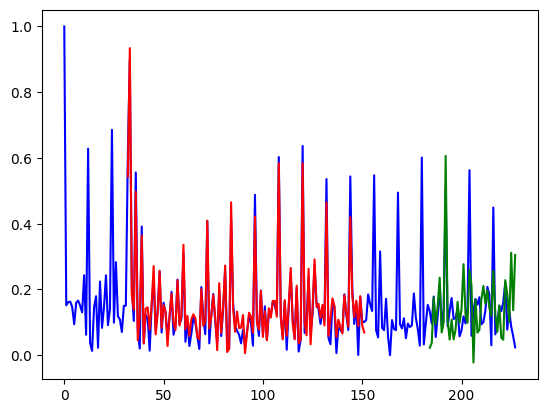

In [12]:
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred = lstm(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = lstm(X_train)[:, -1, :]
    # shift test predictions for plotting
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size+lookback:len(timeseries)] = lstm(X_test)[:, -1, :]
# plot
plt.plot(timeseries, c='b')
plt.plot(train_plot, c='r')
plt.plot(test_plot, c='g')
plt.show()

In [9]:
transformer = Transformer(feature_size=250, num_layers=1, dropout=0.1)
optimizer = optim.AdamW(transformer.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train,y_train),shuffle=True,batch_size=8)

/Users/chris_lo/PycharmProjects/TimeSeries/.venv/lib/python3.11/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [10]:
n_epochs = 4000
for epoch in range(n_epochs):
    transformer.train()
    for X_batch, y_batch in loader:
        y_pred = transformer(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 100 != 0:
        continue
    transformer.eval()
    with torch.no_grad():
        y_pred = transformer(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = transformer(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))


Epoch 0: train RMSE 0.1549, test RMSE 0.1276
Epoch 100: train RMSE 0.1568, test RMSE 0.1319
Epoch 200: train RMSE 0.1696, test RMSE 0.1408
Epoch 300: train RMSE 0.1681, test RMSE 0.1410
Epoch 400: train RMSE 0.1600, test RMSE 0.1346
Epoch 500: train RMSE 0.1825, test RMSE 0.1477
Epoch 600: train RMSE 0.1664, test RMSE 0.1378
Epoch 700: train RMSE 0.1624, test RMSE 0.1347



KeyboardInterrupt

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x10fde0450>>
Traceback (most recent call last):
  File "/Users/chris_lo/PycharmProjects/TimeSeries/.venv/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


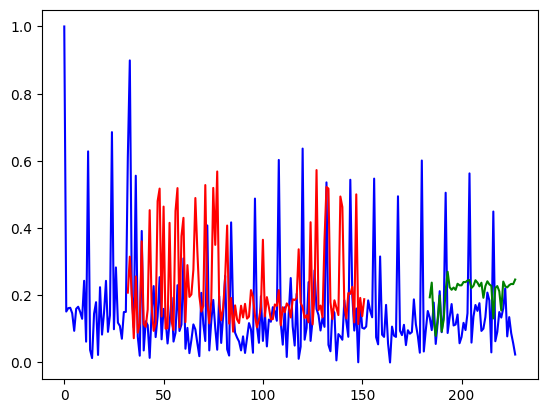

In [13]:
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred = transformer(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = transformer(X_train)[:, -1, :]
    # shift test predictions for plotting
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size+lookback:len(timeseries)] = transformer(X_test)[:, -1, :]
# plot
plt.plot(timeseries, c='b')
plt.plot(train_plot, c='r')
plt.plot(test_plot, c='g')
plt.show()

In [ ]:
X_batch